In [41]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [42]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='orange',label='Real IBM Stock Price')
    plt.plot(predicted, color='green',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [44]:
# First, we get the data
dataset = pd.read_csv('/content/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [45]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

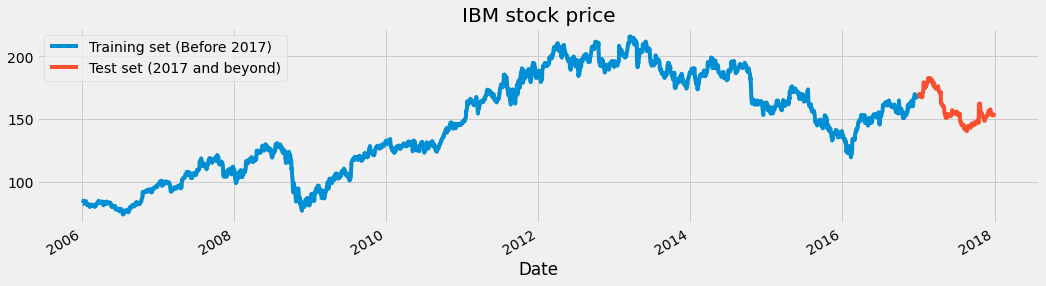

In [46]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [47]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [48]:
# We create a data structure with 60 timesteps and 1 output
# For each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [49]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [50]:
# The RNN architecture
rnn_model = Sequential()
rnn_model.add(SimpleRNN(45,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.18))

rnn_model.add(SimpleRNN(45,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.18))

rnn_model.add(SimpleRNN(45,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.18))

rnn_model.add(Dense(1))

rnn_model.compile(optimizer='rmsprop',loss='mean_squared_error')
rnn_model.fit(X_train,y_train,epochs=45,batch_size=30)


Epoch 1/45
91/91 [==============================] - 3s 33ms/step - loss: 0.1401
Epoch 2/45
91/91 [==============================] - 3s 33ms/step - loss: 0.0370
Epoch 3/45
91/91 [==============================] - 3s 33ms/step - loss: 0.0172
Epoch 4/45
91/91 [==============================] - 3s 34ms/step - loss: 0.0109
Epoch 5/45
91/91 [==============================] - 3s 34ms/step - loss: 0.0079
Epoch 6/45
91/91 [==============================] - 3s 33ms/step - loss: 0.0062
Epoch 7/45
91/91 [==============================] - 3s 34ms/step - loss: 0.0054
Epoch 8/45
91/91 [==============================] - 3s 32ms/step - loss: 0.0044
Epoch 9/45
91/91 [==============================] - 3s 33ms/step - loss: 0.0043
Epoch 10/45
91/91 [==============================] - 3s 33ms/step - loss: 0.0040
Epoch 11/45
91/91 [==============================] - 3s 32ms/step - loss: 0.0036
Epoch 12/45
91/91 [==============================] - 3s 32ms/step - loss: 0.0033
Epoch 13/45
91/91 [==================

In [51]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [52]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = rnn_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

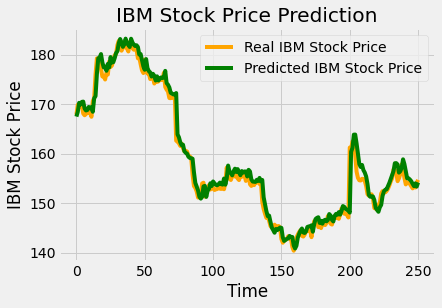

In [53]:
# Visualizing the results for RNN
plot_predictions(test_set,predicted_stock_price)

In [54]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.7726944461728984.


In [55]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=45, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.18))
regressor.add(LSTM(units=45, return_sequences=True))
regressor.add(Dropout(0.18))
regressor.add(LSTM(units=45, return_sequences=True))
regressor.add(Dropout(0.18))
regressor.add(LSTM(units=45))
regressor.add(Dropout(0.18))
regressor.add(Dense(units=1))


regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=45,batch_size=30)

Epoch 1/45
91/91 [==============================] - 9s 100ms/step - loss: 0.0229
Epoch 2/45
91/91 [==============================] - 9s 101ms/step - loss: 0.0104
Epoch 3/45
91/91 [==============================] - 9s 101ms/step - loss: 0.0078
Epoch 4/45
91/91 [==============================] - 9s 104ms/step - loss: 0.0074
Epoch 5/45
91/91 [==============================] - 9s 101ms/step - loss: 0.0058
Epoch 6/45
91/91 [==============================] - 9s 103ms/step - loss: 0.0052
Epoch 7/45
91/91 [==============================] - 10s 105ms/step - loss: 0.0049
Epoch 8/45
91/91 [==============================] - 9s 103ms/step - loss: 0.0046
Epoch 9/45
91/91 [==============================] - 10s 105ms/step - loss: 0.0040
Epoch 10/45
91/91 [==============================] - 9s 104ms/step - loss: 0.0038
Epoch 11/45
91/91 [==============================] - 10s 105ms/step - loss: 0.0036
Epoch 12/45
91/91 [==============================] - 9s 104ms/step - loss: 0.0036
Epoch 13/45
91/91 [===

In [57]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [58]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

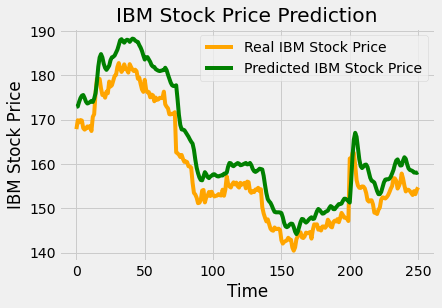

In [59]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [60]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.45726569344694.


In [61]:
# The Bidirectional LSTM architecture
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=90, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor.add(Dropout(0.22))
regressor.add(Bidirectional(LSTM(units=90, return_sequences=True)))
regressor.add(Dropout(0.22))
regressor.add(Bidirectional(LSTM(units=90, return_sequences=True)))
regressor.add(Dropout(0.22))
regressor.add(Bidirectional(LSTM(units=90)))
regressor.add(Dropout(0.22))
regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
regressor.fit(X_train,y_train,epochs=25,batch_size=30)

Epoch 1/25
91/91 [==============================] - 32s 356ms/step - loss: 0.0287
Epoch 2/25
91/91 [==============================] - 33s 365ms/step - loss: 0.0106
Epoch 3/25
91/91 [==============================] - 33s 362ms/step - loss: 0.0068
Epoch 4/25
91/91 [==============================] - 33s 365ms/step - loss: 0.0057
Epoch 5/25
91/91 [==============================] - 33s 363ms/step - loss: 0.0048
Epoch 6/25
91/91 [==============================] - 33s 363ms/step - loss: 0.0044
Epoch 7/25
91/91 [==============================] - 33s 365ms/step - loss: 0.0036
Epoch 8/25
91/91 [==============================] - 33s 368ms/step - loss: 0.0033
Epoch 9/25
91/91 [==============================] - 38s 415ms/step - loss: 0.0033
Epoch 10/25
91/91 [==============================] - 33s 363ms/step - loss: 0.0029
Epoch 11/25
91/91 [==============================] - 33s 365ms/step - loss: 0.0029
Epoch 12/25
91/91 [==============================] - 33s 362ms/step - loss: 0.0028
Epoch 13/25
9

In [62]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [63]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

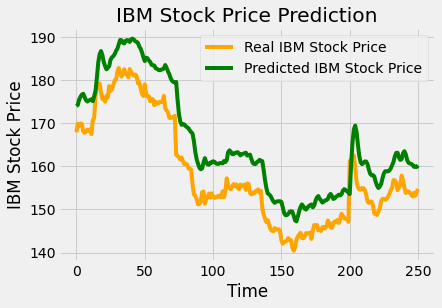

In [64]:
# Visualizing the results for Bidirectional LSTM
plot_predictions(test_set,predicted_stock_price)

In [65]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.440174222037834.


In [66]:
# The GRU architecture
regressorGRU = Sequential()
regressorGRU.add(GRU(units=45, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.18))
regressorGRU.add(GRU(units=45, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.18))
regressorGRU.add(GRU(units=45, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.18))
regressorGRU.add(GRU(units=45, activation='tanh'))
regressorGRU.add(Dropout(0.18))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.fit(X_train,y_train,epochs=45,batch_size=135)

Epoch 1/45
21/21 [==============================] - 4s 175ms/step - loss: 0.1029
Epoch 2/45
21/21 [==============================] - 4s 181ms/step - loss: 0.0298
Epoch 3/45
21/21 [==============================] - 4s 193ms/step - loss: 0.0061
Epoch 4/45
21/21 [==============================] - 4s 183ms/step - loss: 0.0049
Epoch 5/45
21/21 [==============================] - 4s 182ms/step - loss: 0.0041
Epoch 6/45
21/21 [==============================] - 4s 186ms/step - loss: 0.0041
Epoch 7/45
21/21 [==============================] - 4s 186ms/step - loss: 0.0037
Epoch 8/45
21/21 [==============================] - 4s 183ms/step - loss: 0.0036
Epoch 9/45
21/21 [==============================] - 4s 184ms/step - loss: 0.0032
Epoch 10/45
21/21 [==============================] - 4s 183ms/step - loss: 0.0032
Epoch 11/45
21/21 [==============================] - 4s 185ms/step - loss: 0.0031
Epoch 12/45
21/21 [==============================] - 4s 184ms/step - loss: 0.0030
Epoch 13/45
21/21 [======

In [67]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

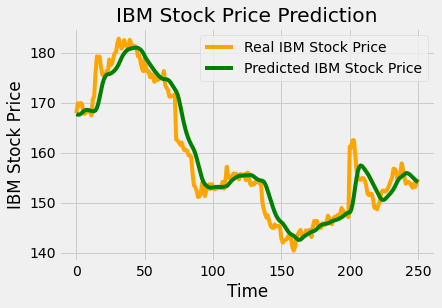

In [68]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [69]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.2308311736643907.
